### Power and coherence are dynamic

In [1]:
import sys

sys.path.insert(1, "/home/vinicius/storage1/projects/GrayData-Analysis")

In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import xarray as xr
from frites.stats import confidence_interval
from frites.utils import parallel_func
from mne.stats import fdr_correction
from tqdm import tqdm
from utils import *

from config import get_dates, return_delay_split
from GDa.flatmap.flatmap import flatmap
from GDa.loader import loader

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


##### Setting configurations

In [3]:
_ROOT = os.path.expanduser("~/funcog/gda/")

In [4]:
metric = "coh"
monkey = "lucy"
ds = 1

In [5]:
early_cue, early_delay = return_delay_split(monkey, delay_type=ds)

In [6]:
sessions = get_dates(monkey)

In [7]:
stages = [[-0.4, 0], [0, 0.4], [0.5, 0.9], [0.9, 1.3], [1.1, 1.5]]
stage_labels = ["P", "S", "D1", "D2", "Dm"]

##### Auxiliar functions

In [8]:
import numba


@numba.njit
def _histogram(x, bins):
    return np.histogram(x, bins=bins)[0]


def signal_entropy(power, nbins=20):

    counts = np.apply_along_axis(_histogram, -1, power, bins=nbins)

    pk = counts / counts.sum(-1)[..., np.newaxis]

    H = stats.entropy(pk, qk=None, base=None, axis=-1) / np.log(nbins)
    H = xr.DataArray(
        H,
        dims=("roi", "freqs", "trials"),
        coords=(power.roi, power.freqs, power.trials),
    )

    return H

In [9]:
def compute_time_series_cv(data, nbins=10):
    """
    Compute the coefficient of variation (CV) of a time series.

    The CV is defined as the standard deviation divided by the mean of the time series. This function also computes a confidence interval for the CV at a specified level.

    Parameters
    ----------
    data : xarray.DataArray
        The time series data. It should have dimensions 'roi', 'trials', and 'times'.

    Returns
    -------
    cv : xarray.DataArray
        The coefficient of variation of the time series data. It has dimensions 'roi', 'trials', and 'times'.
    """
    cv = signal_entropy(data, nbins=nbins)  # data.std("times") / data.mean("times")
    return confidence_interval(cv, cis=95, axis=2, n_boots=1000, verbose=False)

In [10]:
data_loader = loader(_ROOT=_ROOT)

In [83]:
colors = dict(
    zip(
        [
            "motor",
            "parietal",
            "prefrontal",
            "somatosensory",
            "temporal",
            "visual",
            "auditory",
        ],
        ["r", "aqua", "b", "m", "goldenrod", "green", "brown"],
    )
)

#### Single sessions

In [12]:
kw_loader = dict(
    session="141024", aligned_at="cue", channel_numbers=False, monkey=monkey
)

In [13]:
power_task = data_loader.load_power(**kw_loader, trial_type=1, behavioral_response=1)
power_fix = data_loader.load_power(**kw_loader, trial_type=2, behavioral_response=0)

In [14]:
_, rois, freqs, times = power_task.coords.values()

In [15]:
# Get the region name for each roi
areas_dict = get_areas()
regions = np.asarray([areas_dict[roi.lower()] for roi in rois.data])

In [16]:
cv_task = compute_time_series_cv(power_task)
cv_fix = compute_time_series_cv(power_fix)

In [17]:
x = cv_task.assign_coords({"roi": regions}).groupby("roi").median("roi").squeeze()
y = cv_fix.assign_coords({"roi": regions}).groupby("roi").median("roi").squeeze()

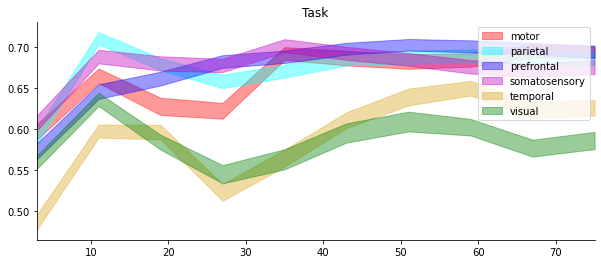

In [18]:
plt.figure(figsize=(10, 4))
ax = plt.subplot(111)
for r in np.unique(regions):

    plt.fill_between(
        freqs,
        x.sel(bound="low", roi=r),
        x.sel(bound="high", roi=r),
        alpha=0.4,
        color=colors[r],
        label=r,
    )
plt.xlim(3, 75)
[ax.spines[key].set_visible(False) for key in ["top", "right"]]
plt.title("Task")
plt.legend()

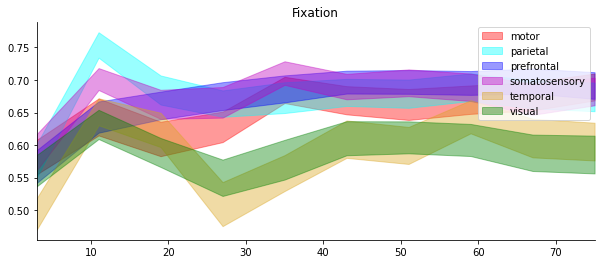

In [19]:
plt.figure(figsize=(10, 4))
ax = plt.subplot(111)
for r in np.unique(regions):

    plt.fill_between(
        freqs,
        y.sel(bound="low", roi=r),
        y.sel(bound="high", roi=r),
        alpha=0.4,
        color=colors[r],
        label=r,
    )
plt.xlim(3, 75)
[ax.spines[key].set_visible(False) for key in ["top", "right"]]
plt.title("Fixation")
plt.legend()

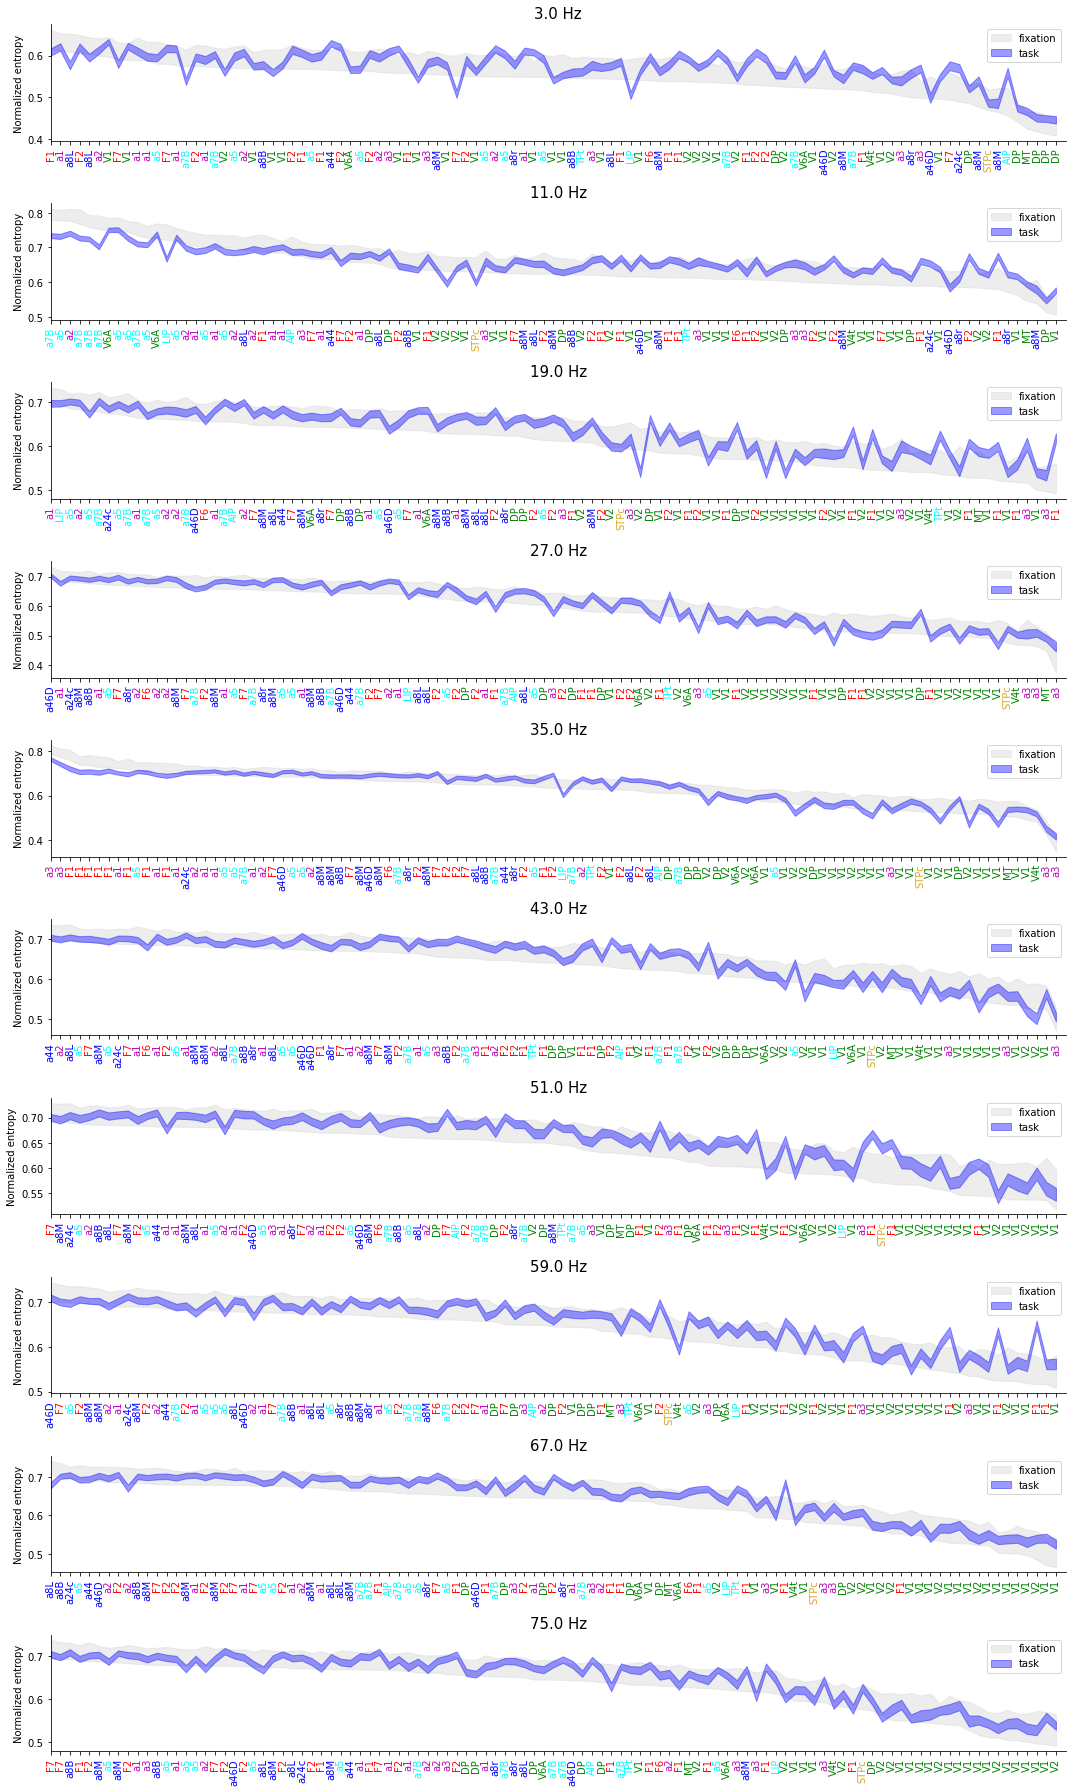

In [20]:
plt.figure(figsize=(15, 25))
freqs = power_task.freqs.data
for fi, freq in enumerate(freqs):

    ax = plt.subplot(10, 1, fi + 1)
    # Fixation
    lower = cv_fix.squeeze().sel(bound="low", freqs=freq)
    higher = cv_fix.squeeze().sel(bound="high", freqs=freq)
    idx = np.argsort(lower)[::-1].data
    plt.fill_between(range(105), lower[idx], higher[idx], color="lightgrey", alpha=0.4)
    # Task
    lower = cv_task.squeeze().sel(bound="low", freqs=freq)
    higher = cv_task.squeeze().sel(bound="high", freqs=freq)
    plt.fill_between(range(105), lower[idx], higher[idx], color="b", alpha=0.4)
    tks = plt.xticks(range(105), rois.data[idx], rotation=90)
    [tks[1][i].set_color(colors[r]) for i, r in enumerate(regions[idx])]
    plt.legend(["fixation", "task"])
    plt.xlim([0, 105])
    [ax.spines[key].set_visible(False) for key in ["top", "right"]]
    plt.ylabel("Normalized entropy")
    plt.title(f"{freq} Hz", fontsize=15)
plt.tight_layout()
plt.savefig(f"figures/n1/cv_dist_single_session.pdf", dpi=600)

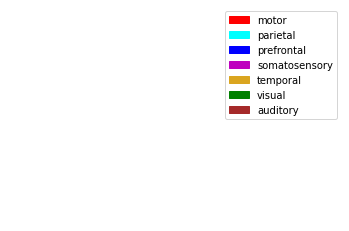

In [21]:
import matplotlib.patches as mpatches

patches = []
for key in colors.keys():
    patches += [mpatches.Patch(color=colors[key], label=key)]
plt.legend(handles=patches)
plt.axis("off")
plt.savefig(f"figures/n1/regions_colors.pdf", dpi=600)

In [22]:
def compute_power_pval(power_task, power_fix, stages):
    pvals = []
    for t0, t1 in stages:
        _, temp = stats.kruskal(
            power_fix.sel(times=slice(t0, t1)),
            power_task.sel(times=slice(t0, t1)),
            axis=(2, 3),
        )
        pvals += [temp]

    _, pvals = fdr_correction(np.stack(pvals, -1))
    pvals = xr.DataArray(
        pvals,
        dims=("roi", "freqs", "times"),
        coords=(power_fix.roi, freqs, stage_labels),
    )

    return pvals


def compute_crackle_pval(raster_task, raster_fix, stages):
    pvals = []
    for i in range(raster_task.sizes["times"]):
        _, temp = stats.kruskal(
            raster_fix.isel(times=i),
            raster_task.isel(times=i),
            axis=2,
        )
        pvals += [temp]

    _, pvals = fdr_correction(np.stack(pvals, -1))
    pvals = xr.DataArray(
        pvals,
        dims=("roi", "freqs", "times"),
        coords=(raster_task.roi, freqs, stage_labels),
    )

    return pvals


def plot_tile_maps(values, regions, vmin=0, vmax=0.8, cmap="viridis"):
    idx = np.argsort(regions)

    for i in range(values.sizes["times"]):

        plt.subplot(1, len(stages), i + 1)

        plt.imshow(
            values.isel(times=i)[idx],
            aspect="auto",
            origin="lower",
            cmap=cmap,
            vmin=vmin,
            vmax=vmax,
        )

        if i == 0:
            tks = plt.yticks(range(len(values.roi)), values.roi.data[idx])
            [tks[1][j].set_color(colors[r]) for j, r in enumerate(regions[idx])]
        else:
            plt.yticks([])

        plt.xticks(range(len(freqs)), values.freqs.data.astype(int), rotation=90)
        plt.xlabel("Hz")
        plt.title(f"{values.times[i].data}")

In [23]:
power_pvals = compute_power_pval(power_task, power_fix, stages)

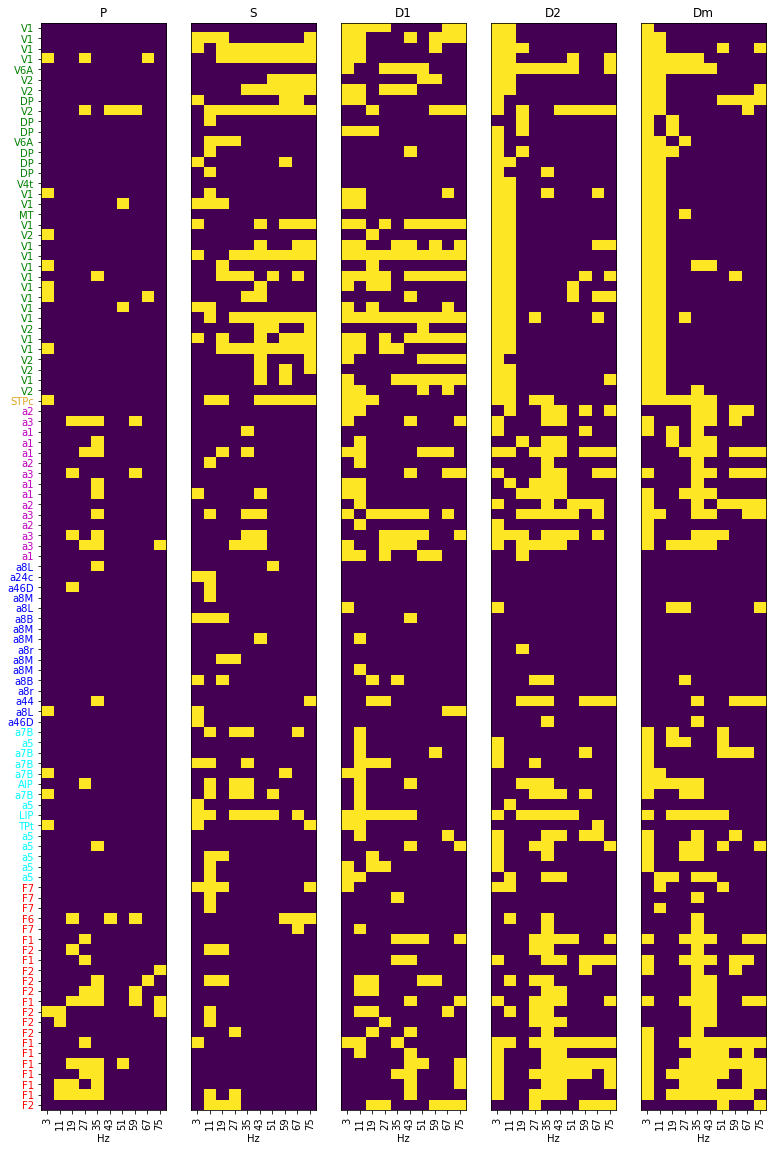

In [24]:
plt.figure(figsize=(13, 20))
plot_tile_maps(power_pvals <= 0.0001, regions)

In [25]:
thr_fix = power_fix.quantile(0.9, ("trials", "times"))
thr_task = power_task.quantile(0.9, ("trials", "times"))

raster_fix = []
raster_task = []

for t0, t1 in tqdm(stages):
    raster_fix += [(power_fix >= thr_fix).sel(times=slice(t0, t1)).mean("times")]
    raster_task += [(power_task >= thr_task).sel(times=slice(t0, t1)).mean("times")]

100%|██████████| 5/5 [00:00<00:00,  5.03it/s]


In [26]:
raster_task = xr.concat(raster_task, "times").transpose(*power_task.dims)
raster_fix = xr.concat(raster_fix, "times").transpose(*power_task.dims)

In [27]:
crk_pvals = compute_crackle_pval(raster_task, raster_fix, stages)

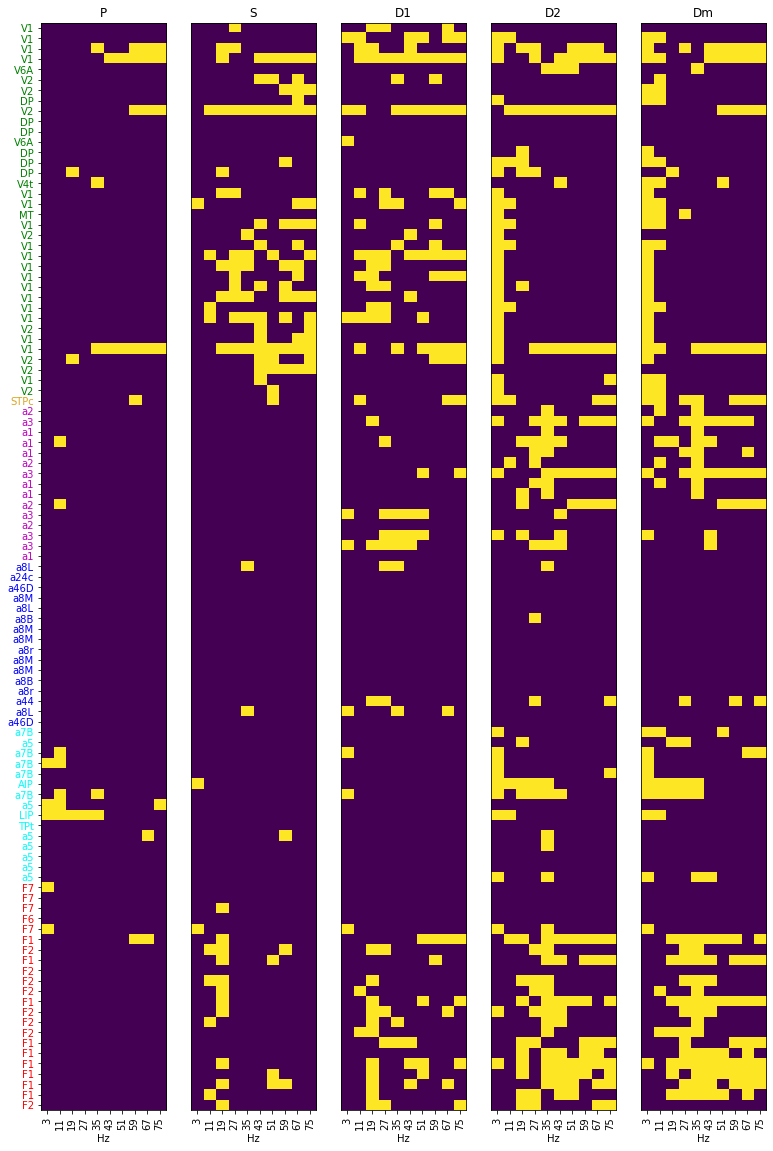

In [28]:
plt.figure(figsize=(13, 20))
plot_tile_maps(crk_pvals <= 0.01, regions)

In [29]:
def plot_power_ts(power):
    it = np.random.choice(range(power.sizes["trials"]), 20)
    H = signal_entropy(power, nbins=7)
    power_plot = power.sel(freqs=27, times=slice(-0.5, 2)).isel(roi=0, trials=it)
    # cv = power_plot.sel(times=slice(0.5, 1.5)).std("times") / power_plot.sel(times=slice(0.5, 1.5)).mean("times")
    # print(cv.shape)

    power_plot = (power_plot - power_plot.mean("times")) / power_plot.std("times")
    H = H.sel(freqs=27).isel(roi=33, trials=it)
    plt.figure(figsize=(10, 16))
    ax = plt.subplot(111)
    for i in range(20):
        (power_plot[i] + 3 * i).plot(x="times", hue="trials", color="b", lw=1)
        plt.text(2.1, 3 * i, f"{H[i]:.2f}")

    plt.vlines(0, -2, 60, color="k")
    plt.vlines(0.5, -2, 60, color="k")
    plt.vlines(1.5, -2, 60, color="k")

    plt.hlines(62, -0.4, 0, color="k", lw=3)
    plt.hlines(62, 0, 0.4, color="g", lw=3)
    plt.hlines(62, 0.5, 0.9, color="b", lw=3)
    plt.hlines(62, 0.9, 1.3, color="r", lw=3)
    plt.hlines(61, 1.1, 1.5, color="purple", lw=3)

    plt.text(-0.2, 63, "P", fontsize=15)
    plt.text(0.15, 63, "S", fontsize=15)
    plt.text(0.67, 63, "D1", fontsize=15)
    plt.text(1.04, 63, "D2", fontsize=15)
    plt.text(1.36, 62, "Dm", fontsize=15)

    plt.text(2.1, 62, "H", fontsize=15)

    # ax.get_legend().remove()
    [ax.spines[key].set_visible(False) for key in ["top", "right", "left", "bottom"]]
    plt.axis("off")
    plt.title("")

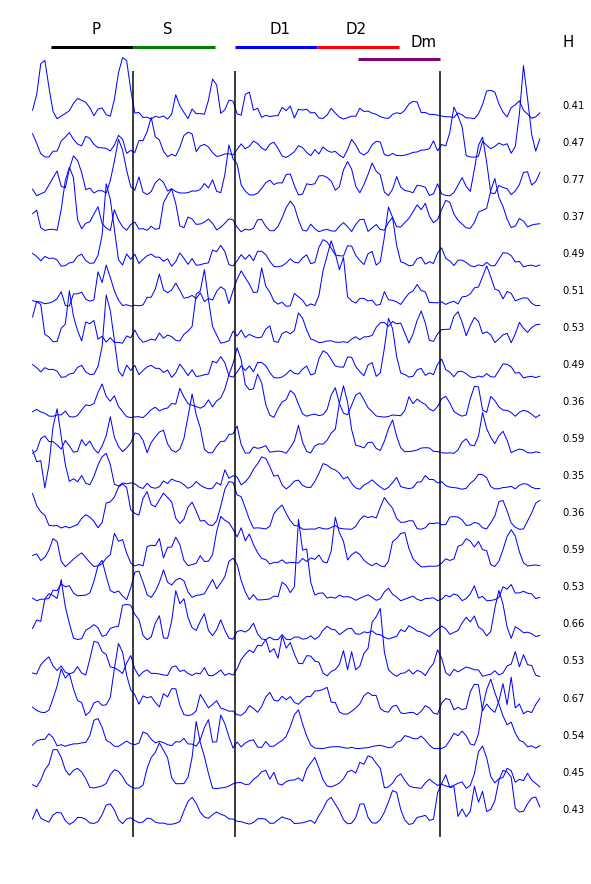

In [30]:
plot_power_ts(power_task)
plt.savefig(f"figures/n1/time_series_task.pdf", dpi=600, bbox_inches="tight")

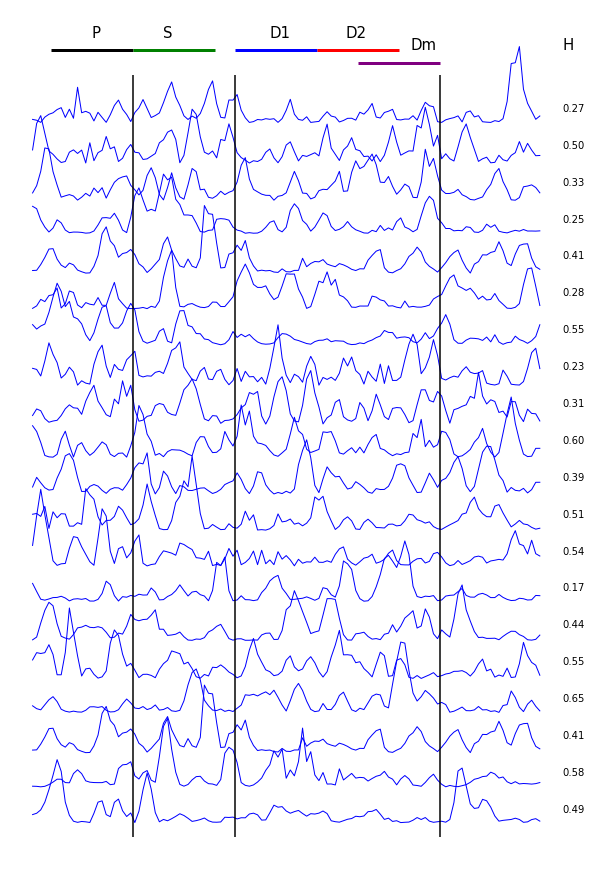

In [31]:
plot_power_ts(power_fix)
plt.savefig(f"figures/n1/time_series_fix.pdf", dpi=600, bbox_inches="tight")

#### All sessions

In [32]:
cv_fix = []
cv_task = []
for session in tqdm(sessions):

    kw_loader = dict(aligned_at="cue", channel_numbers=False, monkey=monkey)

    power_task = data_loader.load_power(
        **kw_loader, trial_type=1, behavioral_response=1, session=session
    )

    power_fix = data_loader.load_power(
        **kw_loader, trial_type=2, behavioral_response=0, session=session
    )

    cv_fix += [compute_time_series_cv(power_fix)]
    cv_task += [compute_time_series_cv(power_task)]

100%|██████████| 62/62 [04:13<00:00,  4.09s/it]


In [33]:
cv_fix = node_xr_remove_sca(data_loader.apply_min_rois(cv_fix, 10))
cv_task = node_xr_remove_sca(data_loader.apply_min_rois(cv_task, 10))

In [34]:
rois = cv_task.roi.data

In [35]:
n = np.asarray([areas_dict[roi.lower()] for roi in rois])

In [36]:
cv_task = cv_task.assign_coords(dict(roi=n))
cv_fix = cv_fix.assign_coords(dict(roi=n))

In [37]:
x = cv_task.groupby("roi").median("roi").squeeze()
y = cv_fix.groupby("roi").median("roi").squeeze()

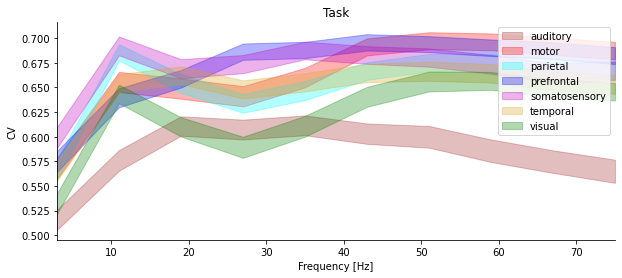

In [38]:
plt.figure(figsize=(10, 4))
ax = plt.subplot(111)
for r in np.unique(x.roi.data):

    plt.fill_between(
        freqs,
        x.sel(bound="low", roi=r),
        x.sel(bound="high", roi=r),
        alpha=0.3,
        color=colors[r],
        label=r,
    )
plt.xlim(3, 75)
plt.xlabel("Frequency [Hz]")
plt.ylabel("CV")
[ax.spines[key].set_visible(False) for key in ["top", "right"]]
plt.title("Task")
plt.legend()
plt.savefig("figures/n1/cv_all_sessions_task.pdf")

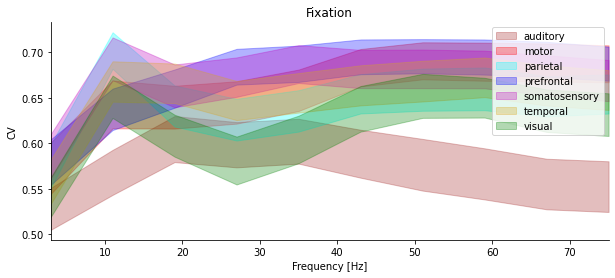

In [39]:
plt.figure(figsize=(10, 4))
ax = plt.subplot(111)
for r in np.unique(x.roi.data):

    plt.fill_between(
        freqs,
        y.sel(bound="low", roi=r),
        y.sel(bound="high", roi=r),
        alpha=0.3,
        color=colors[r],
        label=r,
    )
plt.xlim(3, 75)
[ax.spines[key].set_visible(False) for key in ["top", "right"]]
plt.xlabel("Frequency [Hz]")
plt.ylabel("CV")
plt.title("Fixation")
plt.legend()
plt.savefig("figures/n1/cv_all_sessions_fixation.pdf")

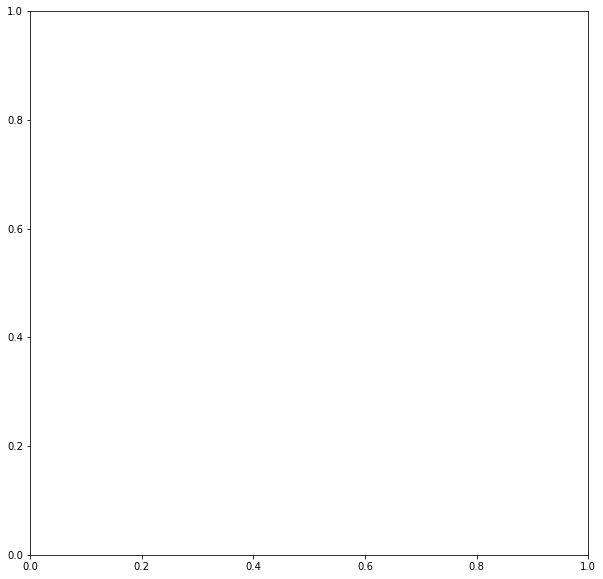

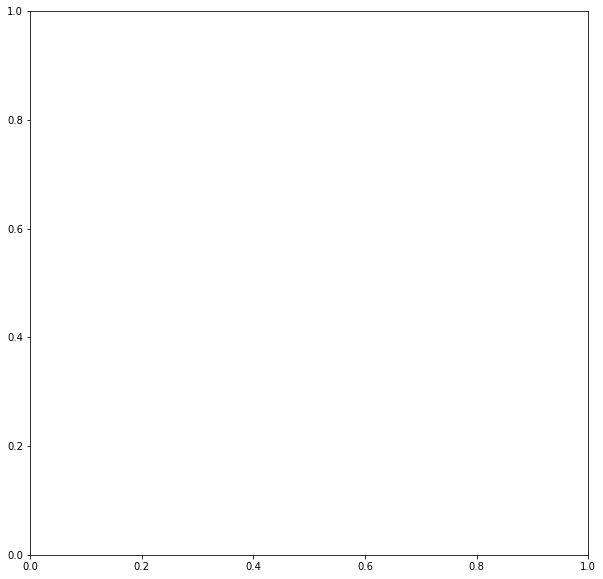

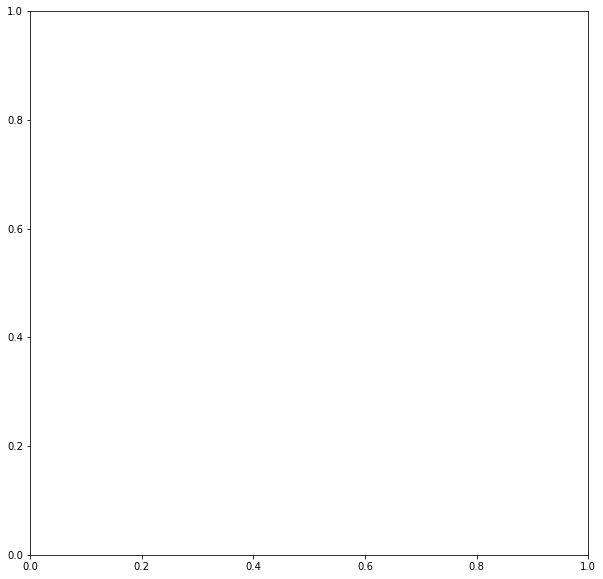

In [67]:
for f in [11, 27, 67]:

    fig = plt.figure(figsize=(5, 10), dpi=600)

    gs0 = fig.add_gridspec(
        nrows=1,
        ncols=2,
        left=0.05,
        right=0.95,
        wspace=0.1,
        bottom=0.75,
        top=0.95,
        width_ratios=(1.0, 0.1),
    )

    ax1 = plt.subplot(gs0[0])
    if f == 67:
        ax2 = plt.subplot(gs0[1])
    else:
        ax2 = None

    areas = [a.lower() for a in rois]
    values = cv_task.sel(freqs=f).mean("bound").squeeze()
    fmap = flatmap(values.data, areas)

    plt.figure(figsize=(10, 10))
    ax = plt.subplot(111)

    # Only plot colorbar for last column
    fmap.plot(
        ax1,
        ax_colorbar=ax2,
        cbar_title="Norm. entropy",
        alpha=0.6,
        vmin=.5,
        vmax=.7,
        colormap="Greys",
    )
    plt.title(f"{f} Hz")

    plt.savefig(f"figures/n1/{f}hzmap.png", bbox_inches="tight")
    plt.close()

In [41]:
power = []
power_pval = []
crk_pval = []
for session in tqdm(sessions):

    kw_loader = dict(aligned_at="cue", channel_numbers=False, monkey=monkey)

    power_task = data_loader.load_power(
        **kw_loader, trial_type=1, behavioral_response=1, session=session
    )

    power_fix = data_loader.load_power(
        **kw_loader, trial_type=2, behavioral_response=0, session=session
    )

    thr_fix = power_fix.quantile(0.9, ("trials", "times"))
    thr_task = power_task.quantile(0.9, ("trials", "times"))

    raster_fix = []
    raster_task = []

    for t0, t1 in stages:
        raster_fix += [(power_fix >= thr_fix).sel(times=slice(t0, t1)).mean("times")]
        raster_task += [(power_task >= thr_task).sel(times=slice(t0, t1)).mean("times")]

    raster_task = xr.concat(raster_task, "times").transpose(*power_task.dims)
    raster_fix = xr.concat(raster_fix, "times").transpose(*power_task.dims)

    power_pval += [compute_power_pval(power_task, power_fix, stages) <= 0.01]
    crk_pval += [compute_crackle_pval(raster_task, raster_fix, stages) <= 0.01]
    power += [
        xr.concat(
            [
                power_task.sel(times=slice(t0, t1)).mean(("times", "trials"))
                for t0, t1 in stages
            ],
            "times",
        )
    ]

100%|██████████| 62/62 [11:15<00:00, 10.89s/it]


In [42]:
power = data_loader.apply_min_rois(power, 10)
power_pval = data_loader.apply_min_rois(power_pval, 10)
crk_pval = data_loader.apply_min_rois(crk_pval, 10)

In [43]:
df = (power * (crk_pval > 0.3)).to_dataframe("power").reset_index()
df = df.loc[df.power > 0]

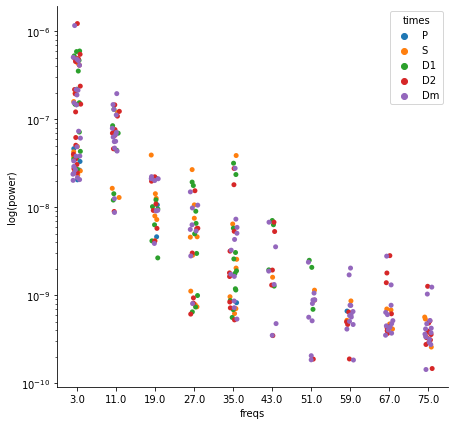

In [91]:
f, ax = plt.subplots(figsize=(7, 7))
sns.stripplot(data=df, hue="times", x="freqs", y="power")
ax.set(yscale="log")
plt.ylabel("log(power)")
[ax.spines[key].set_visible(False) for key in ["top", "right"]]
plt.savefig(f"figures/n1/pdist_03.pdf", bbox_inches="tight")

In [45]:
power_pval = node_xr_remove_sca(power_pval)
crk_pval = node_xr_remove_sca(crk_pval)

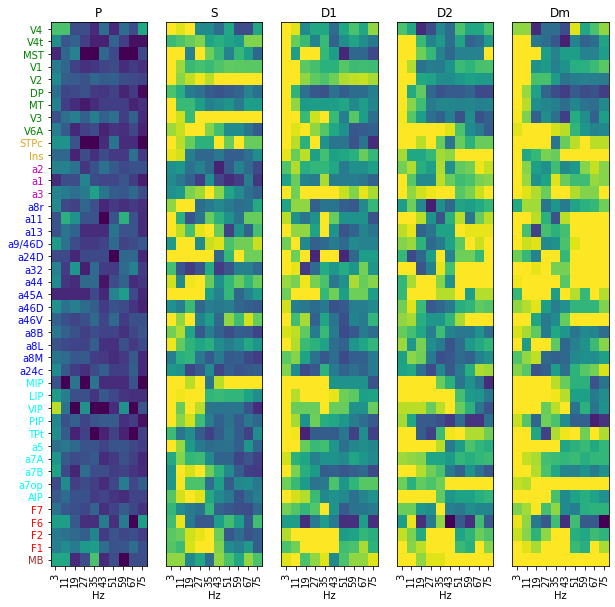

In [46]:
plt.figure(figsize=(10, 10))
plot_tile_maps(
    power_pval,
    np.asarray([areas_dict[roi.lower()] for roi in power_pval.roi.data]),
    vmin=0,
    vmax=0.6,
)
plt.savefig("figures/n1/sig_power.png")

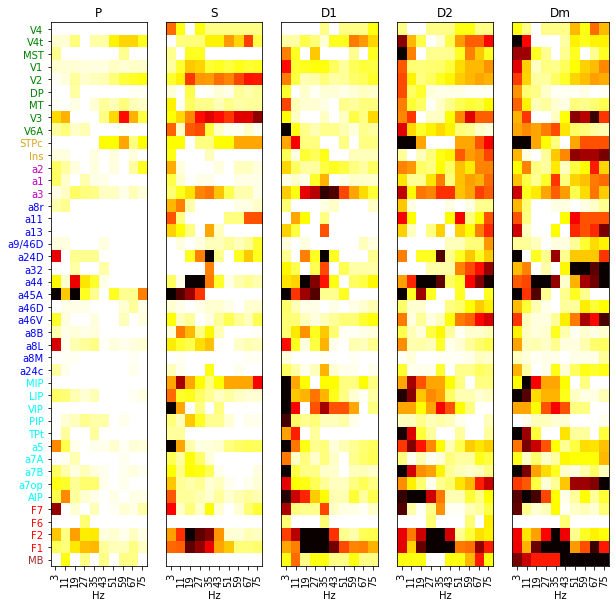

In [47]:
plt.figure(figsize=(10, 10))
plot_tile_maps(
    crk_pval,
    np.asarray([areas_dict[roi.lower()] for roi in power_pval.roi.data]),
    vmin=0,
    vmax=0.6,
    cmap="hot_r",
)
plt.savefig("figures/n1/sig_crackle.png")

In [48]:
def plot_tile_map(ax, values, regions, time, vmin=0, vmax=0.8, cmap="viridis"):
    plt.sca(ax)
    idx = np.argsort(regions)
    
    freqs = values.freqs

    plt.imshow(
        values.isel(times=time)[idx],
        aspect="auto",
        origin="lower",
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
    )

    if time == 0:
        tks = plt.yticks(range(len(values.roi)), values.roi.data[idx])
        [tks[1][j].set_color(colors[r]) for j, r in enumerate(regions[idx])]
    else:
        plt.yticks([])

    plt.xticks(range(len(freqs)), values.freqs.data.astype(int), rotation=90)
    plt.xlabel("Hz")
    plt.title(f"{values.times[time].data}")

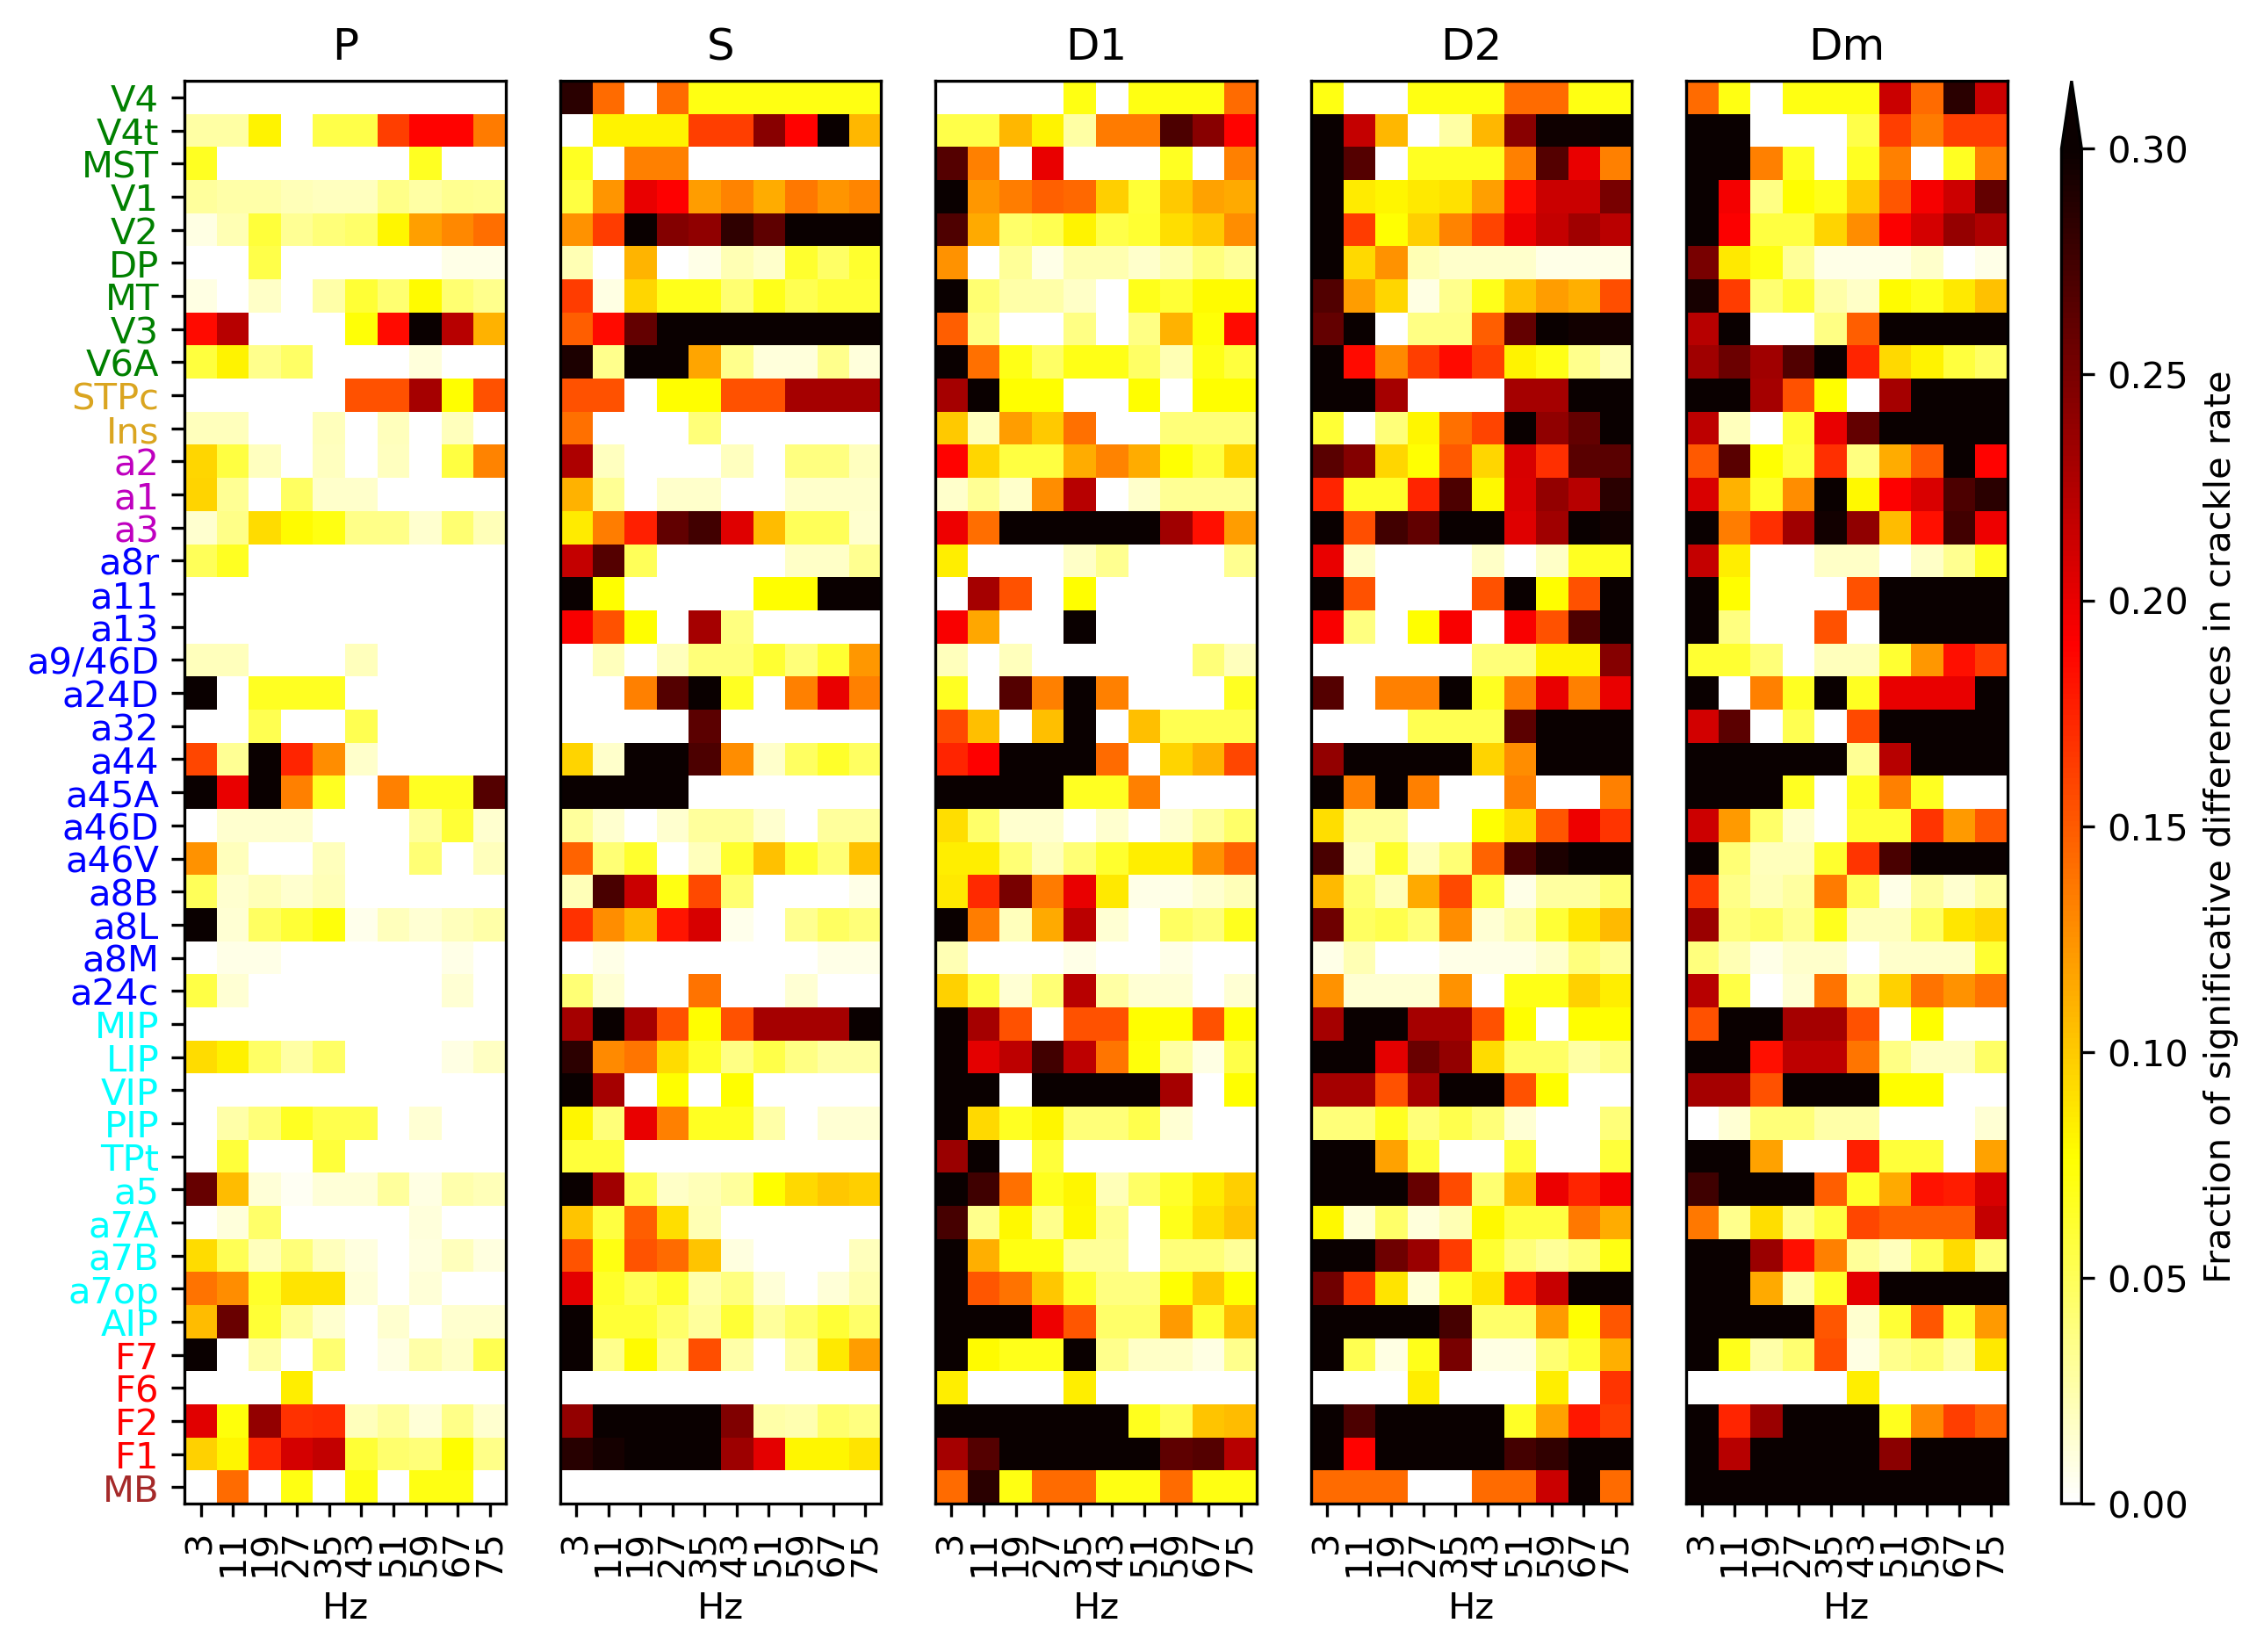

In [90]:
fig = plt.figure(figsize=(8, 20), dpi=300)

gs0 = fig.add_gridspec(
    nrows=1,
    ncols=6,
    left=0.05,
    right=0.95,
    wspace=0.2,
    bottom=0.68,
    top=0.95,
    width_ratios=[.8, .8, .8, .8, .8, 0.05],
)

axs = [plt.subplot(gs0[i]) for i in range(6)]

for time, ax in enumerate(axs[:-1]):

    plt.sca(ax)

    plot_tile_map(
        ax,
        crk_pval,
        np.asarray([areas_dict[roi.lower()] for roi in crk_pval.roi.data]),
        time,
        vmin=0,
        vmax=0.3,
        cmap="hot_r",
    )

    
import matplotlib
norm = matplotlib.colors.Normalize(vmin=0,
                                   vmax=0.3)
cmap = matplotlib.cm.get_cmap("hot_r")

cbar = plt.colorbar(
    mappable=plt.cm.ScalarMappable(cmap=cmap, norm=norm),
    cax=axs[5], extend='max')
cbar.ax.set_ylabel(
    "Fraction of significative differences in crackle rate", rotation='vertical', fontsize=10);
plt.savefig("figures/n1/sig_crackle.pdf", bbox_inches="tight")